In [1]:
import importlib
import requirements
importlib.reload(requirements)
from requirements import *

In [2]:
class LSTM(nn.Module):
    def __init__(self, dataset:Dataset, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.dataset = dataset
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size=dataset.shape[2], hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dense = nn.Linear(hidden_size, hidden_size//2)
        self.fc = nn.Linear(hidden_size//2, len(dataset.labels))
        self.train_loss, self.val_loss, self.train_accuracy, self.val_accuracy = [0, 0], [0, 0], [0, 0], [0, 0]

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        last_output = self.dropout(last_output)
        last_output = self.layer_norm(last_output)
        last_output = torch.relu(self.dense(last_output))
        last_output = self.dropout(last_output)
        return self.fc(last_output)

    def validation(self, max, threshold):
        if self.train_accuracy[-1] >= max and self.val_accuracy[-1] >= max:
            return True
        return np.var(self.train_accuracy[-5:]) <= threshold

    def graph(self, save_name=''):
        tacc, vacc = self.train_accuracy, self.train_accuracy
        tlos, vlos = [i if (i <= 1.0 and i != 0.0) else 1.0 for i in self.train_loss], [i if (i <= 1.0 and i != 0.0) else 1.0 for i in self.val_loss]
        plt.figure(figsize=(14, 7))
        plt.plot(range(1, len(tacc) + 1), tacc, label='Acurácia de Treino')
        plt.plot(range(1, len(vacc) + 1), vacc, label='Acurácia de Validação')
        plt.plot(range(1, len(tlos) + 1), tlos, label='Perda de Treino')
        plt.plot(range(1, len(vlos) + 1), vlos, label='Perda de Validação')
        plt.xlabel('Épocas')
        plt.ylabel('Valor')
        plt.title('Métricas por Épocas')
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.7), fontsize=12, frameon=True, fancybox=True, shadow=True)
        plt.grid(True)
        if save_name:
            plt.savefig(f'OUTPUT/GRAPHS/{save_name}.png', format='png', dpi=500)
        plt.show()

    def save_model(self, name: str):
        torch.save(self, f'OUTPUT/MODELS/{name}.pth')

    def train_model(self, epochs, batch_size, learning_rate, weight_decay, max=0.99, threshold=1e-10, train_ratio=0.8):
        train_dataset, val_dataset = random_split(self.dataset, [int(train_ratio * len(self.dataset)), len(self.dataset) - int(train_ratio * len(self.dataset))])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        bar = TrainingBar(model=self, train_size=len(train_loader), val_size=len(val_loader), epochs=epochs)
        for epoch in range(epochs):
            bar.reset(epoch)
            self.train()
            sum_loss = 0
            all_train_preds, all_train_labels, all_val_preds, all_val_labels = [], [], [], []
            for batch_data, batch_labels in train_loader:
                optimizer.zero_grad()
                outputs = self(batch_data)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                _, preds = torch.max(outputs, 1)
                all_train_preds.extend(preds.cpu().numpy())
                all_train_labels.extend(batch_labels.cpu().numpy())
                sum_loss += loss.item()
                bar.update()
            sum_loss = 0
            self.eval()
            with torch.no_grad():
                for batch_data, batch_labels in val_loader:
                    outputs = self(batch_data)
                    loss = criterion(outputs, batch_labels)
                    sum_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    all_val_preds.extend(predicted.cpu().numpy())
                    all_val_labels.extend(batch_labels.cpu().numpy())
            self.train_loss.append(sum_loss / len(train_loader))
            self.val_loss.append(sum_loss / len(val_loader))
            self.train_accuracy.append(accuracy_score(all_train_labels, all_train_preds))
            self.val_accuracy.append(accuracy_score(all_val_labels, all_val_preds))
            if self.validation(max, threshold):
                break
        bar.display()

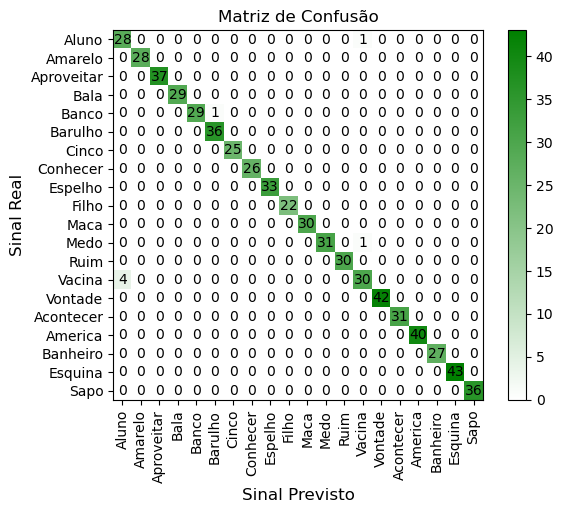

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

model = torch.load("OUTPUT/MODELS/dtw_LSTMmodel.pth", weights_only=False)
glossary = pd.read_csv('glossary.csv')
model.eval()
full_dataset = model.dataset
train_size = int(0.852 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_preds)
labels = glossary.set_index('ID')['SIGNAL'].tolist()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', 'green'])
disp.plot(cmap=cmap, xticks_rotation='vertical', text_kw={'color':'black'})
disp.ax_.set_xlabel("Sinal Previsto", fontsize=12)
disp.ax_.set_ylabel("Sinal Real", fontsize=12)
plt.title("Matriz de Confusão")
plt.show()

In [34]:
model = torch.load("OUTPUT/MODELS/interpolate_RSTmodel2.pth")
df = pd.DataFrame({'TA': model.train_accuracy, 'TL': model.train_loss, 'VA': model.val_accuracy, 'VL': model.val_loss})
df.loc[df['VA'] == max(model.val_accuracy)]

C:\Users\samuel\AppData\Local\Temp\ipykernel_19084\3825658427.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("OUTPUT/MODELS/interpolate_RSTmodel2.pth

AttributeError: Can't get attribute 'SpatialRecurrentTransformerModel' on <module '__main__'>

In [33]:
EPOCHS = 100
BATCH = 16
MAX = 1.0
HIDDEN = 256
LAYERS = 4
DROPOUT = 0.1
LR = 1e-4
WD = 1e-4
dataset = torch.load("OUTPUT/TENSORS/dtw.pt", weights_only=False)
model = LSTM(dataset, hidden_size=HIDDEN, num_layers=LAYERS, dropout=DROPOUT)
model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=LR, weight_decay=WD, max=MAX)

Epoch 2/100:   4%|▎         | 8/217 [00:00<00:11, 17.56it/s, ACC(train)=0.1148, ACC(val)=0.2936, LOSS(train)=0.5642, LOSS(val)=2.2260, DIFF=0.2042]  

KeyboardInterrupt: 

Epoch 2/100:   4%|▎         | 8/217 [00:17<00:11, 17.56it/s, ACC(train)=0.1148, ACC(val)=0.2936, LOSS(train)=0.5642, LOSS(val)=2.2260, DIFF=0.2042]

Epoch 100/100: : 218it [00:16,  7.05it/s, ACC(train)=0.9581, ACC(val)=0.9457, LOSS(train)=0.0428, LOSS(val)=0.1687, DIFF=-0.0126]


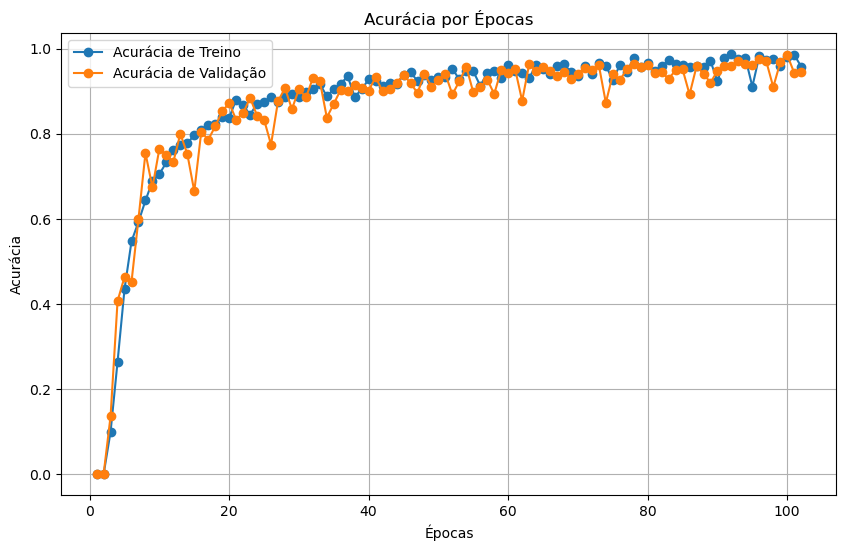

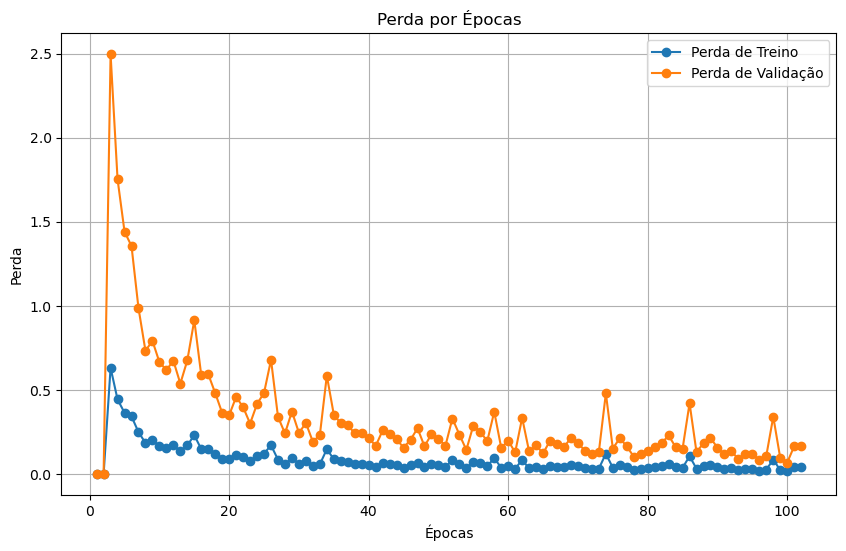

Epoch 100/100: : 218it [00:19,  4.27it/s, ACC(train)=0.8705, ACC(val)=0.8717, LOSS(train)=0.0852, LOSS(val)=0.3360, DIFF=0.0302]


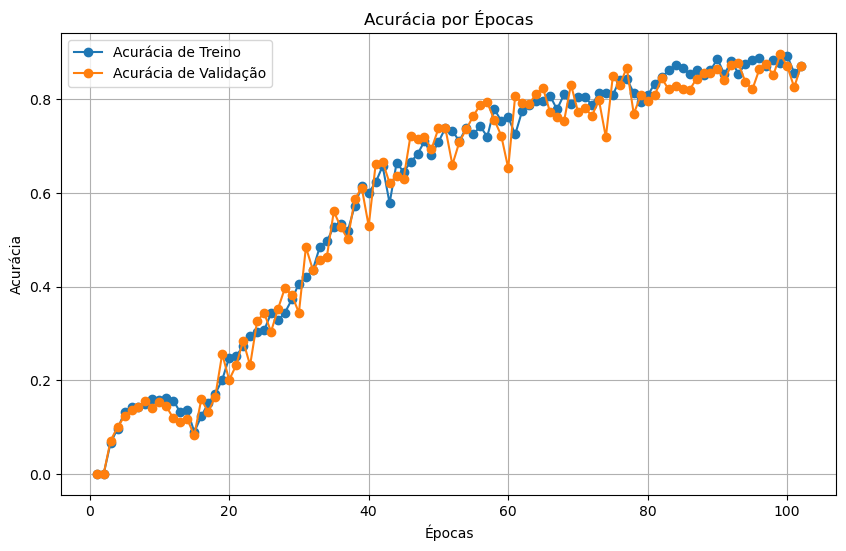

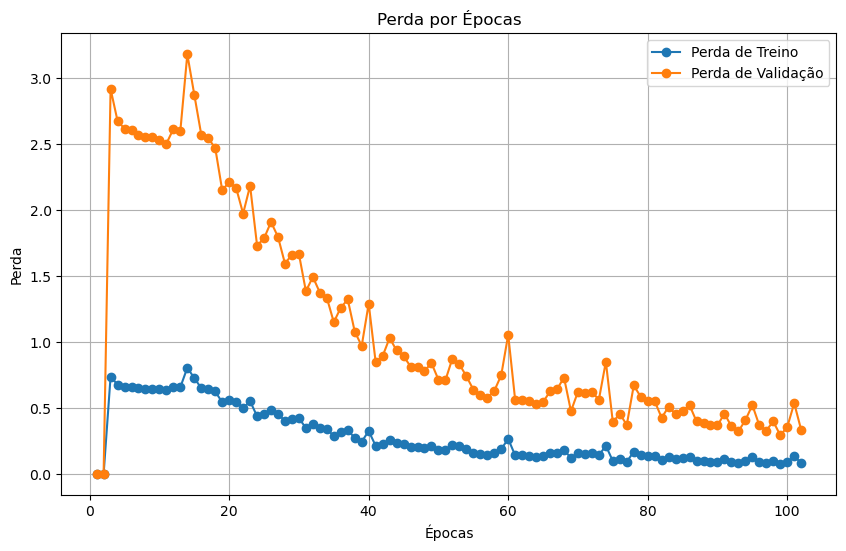

Epoch 100/100: : 218it [00:13,  6.66it/s, ACC(train)=0.9717, ACC(val)=0.9780, LOSS(train)=0.0141, LOSS(val)=0.0556, DIFF=0.0202]


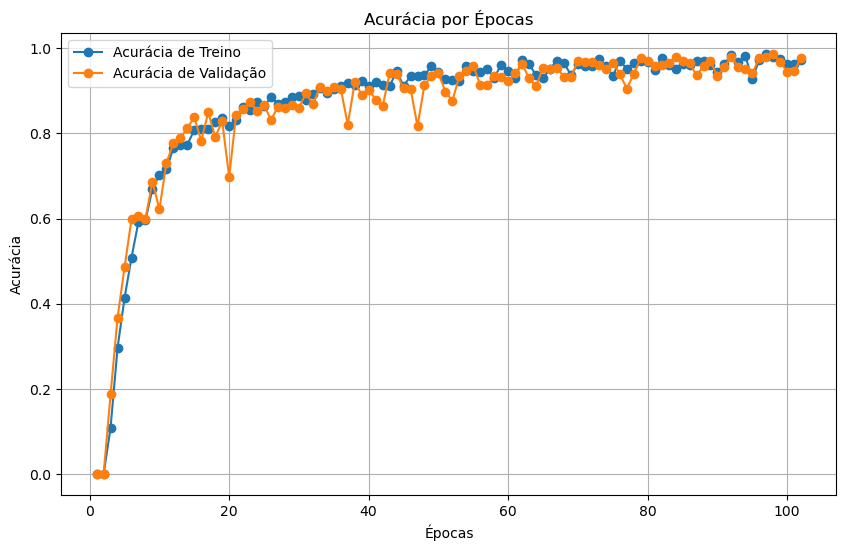

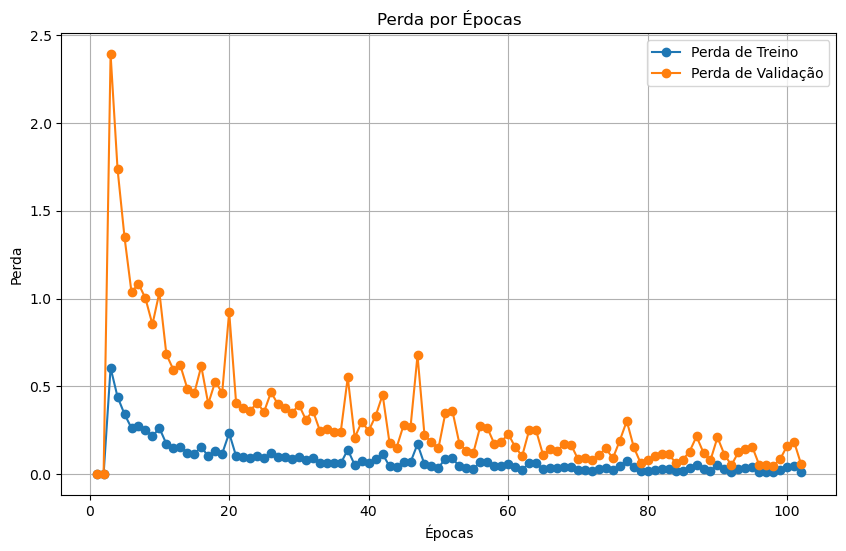

In [35]:
EPOCHS = 100
BATCH = 16
MAX = 1.0
HIDDEN = 256
LAYERS = 4
DROPOUT = 0.1
LR = 1e-4
WD = 1e-4
dataset = torch.load("OUTPUT/TENSORS/interpolate.pt", weights_only=False)
model = LSTM(dataset, hidden_size=HIDDEN, num_layers=LAYERS, dropout=DROPOUT)
model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=LR, weight_decay=WD, max=MAX)
model.graph('interpolate_lstm')
model.save_model('interpolate_lstmmodel')
dataset = torch.load("OUTPUT/TENSORS/padding.pt", weights_only=False)
model = LSTM(dataset, hidden_size=HIDDEN, num_layers=LAYERS, dropout=DROPOUT)
model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=LR, weight_decay=WD, max=MAX)
model.graph('padding_lstm')
model.save_model('padding_lstmmodel')
dataset = torch.load("OUTPUT/TENSORS/dtw.pt", weights_only=False)
model = LSTM(dataset, hidden_size=HIDDEN, num_layers=LAYERS, dropout=DROPOUT)
model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=LR, weight_decay=WD, max=MAX)
model.graph('dtw_lstm')
model.save_model('dtw_lstmmodel')

In [ ]:
EPOCHS = 100
BATCH = 16
MAX = 0.99
HIDDEN = [64, 128, 256, 512]
LAYERS = [2, 4, 8, 10]
DROPOUT = [0.1, 0.2, 0.3]
LR = [9e-5, 1e-4, 2e-4]
WD = [9e-5, 1e-4, 2e-4]
combinations = list(itertools.product(HIDDEN, LAYERS, DROPOUT, LR, WD))
random.shuffle(combinations)
dataset = torch.load("OUTPUT/TENSORS/interpolate.pt", weights_only=False)
for combination in combinations:
    model = LSTM(dataset, hidden_size=combination[0], num_layers=combination[1], dropout=combination[2])
    model.train_model(epochs=EPOCHS, batch_size=BATCH, learning_rate=combination[3], weight_decay=combination[4], max=MAX)
    if model.val_accuracy[-1] >= MAX and model.val_accuracy[-1] >= MAX:
        print(combination)
        model.graph('interpolate_lstm')
        model.save_model('interpolate_LSTMmodel')
        break

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TCC/interpolate.pt'